In [1]:
import ares
import numpy as np
import matplotlib.pyplot as pl
import distpy

In [2]:
data = ares.analysis.GalaxyPopulation() #for lit values

In [3]:
# Independent variables
# redshifts = np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75])
redshifts = np.sort(np.array([0.35, 0.875, 1.125, 1.75, 2.25, 2.75, 1.65, 2.5, 3.5, 0.10165, 0.25, 0.45, 0.575, 0.725, 0.9]))

# redshifts = np.array([0.35, 0.875, 0.10165, 0.25, 0.45, 0.575, 0.725, 0.9])

Ms = np.linspace(7, 12, 60)

# print(Ms)

# blob 1: the smf
blob_n1 = ['galaxy_smf']
blob_i1 = [('z', redshifts), ('logbins', Ms)]
blob_f1 = ['StellarMassFunction']

In [4]:
blob_pars = \
{
 'blob_names': [blob_n1],
 'blob_ivars': [blob_i1],
 'blob_funcs': [blob_f1],
 'blob_kwargs': [None],
}

In [5]:
#define the parameters that remain unchanged
base_pars = ares.util.ParameterBundle('emma:model1')
base_pars.update(blob_pars)

# print(base_pars)
# This is important!
# base_pars['pop_calib_lum'] = None

In [6]:
free_pars = \
[
    'pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]', 
]

is_log = [False, False, False, False, False, False, False, False]

from distpy.distribution import UniformDistribution
from distpy.distribution import DistributionSet

ps = DistributionSet()
ps.add_distribution(UniformDistribution(-1, 4), 'pq_func_par0[0]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[0]')

ps.add_distribution(UniformDistribution(0, 2),   'pq_func_par0[1]')
ps.add_distribution(UniformDistribution(-1, 1),  'pq_func_par2[1]')

ps.add_distribution(UniformDistribution(0, 1),   'pq_func_par0[2]')
ps.add_distribution(UniformDistribution(-3, 1),  'pq_func_par2[2]')

ps.add_distribution(UniformDistribution(10.0, 14.0),   'pq_func_par0[3]')
ps.add_distribution(UniformDistribution(-1, 2),  'pq_func_par2[3]')

In [25]:
#From Moster2010, table 7
logM_0 = 11.88 #(0.01)
# logM_0 = 11.0 #(0.01)

# mu = 0.019 #(0.002)
mu = 2.0 #(0.002)

N_0 = 0.0282 #(0.0003)
nu = -0.72 #(0.06)
gamma_0 = 0.556 #0.001
gamma_1 = -0.26 #(0.05)
beta_0 = 1.06 #(0.06)
beta_1 = 0.17 #(0.12)

guesses = \
{
    'pq_func_par0[0]': beta_0,
    'pq_func_par2[0]': beta_1, 

    #norm
    'pq_func_par0[1]': N_0,
    'pq_func_par2[1]': nu, 

    #gamma
    'pq_func_par0[2]': gamma_0,
    'pq_func_par2[2]': gamma_1, 

    #peak mass
    'pq_func_par0[3]': logM_0,
    'pq_func_par2[3]': mu, 
}

# Loaded $ARES/input/hmf/hmf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


C:\Users\Emma\Anaconda3\lib\site-packages\ares-0.1-py3.7.egg\ares\analysis\GalaxyPopulation.py:1259: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


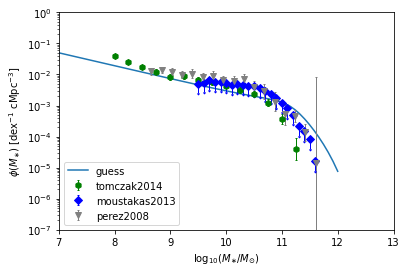

In [29]:
# base_pars
# Ms = np.logspace(7, 12, 60)

base_pars.update(guesses)
pop = ares.populations.GalaxyPopulation(**base_pars)

z = 0.5

smf = pop.StellarMassFunction(z, Ms)

pl.semilogy(Ms, smf, label='guess')
data.PlotSMF(z=z, round_z=0.2, log10Mass=True)

pl.legend()
pl.show()

In [10]:
# Initialize a fitter object and give it the data to be fit
fitter_smf = ares.inference.FitGalaxyPopulation(**base_pars)

fitter_smf.include.append('smf')

# The data can also be provided more explicitly
#I seem to need this or else the run throws error: Must set data by hand! 
# fitter_lf.redshifts = {‘lf’: [5.9]}
fitter_smf.data = 'tomczak2014',  'mortlock2011', 'moustakas2013', 'marchesini2009_10'
#higher z
# fitter_smf.data = 'song2016', 'stefanon2017', 'duncan2014'

# print(fitter_smf.xdata)

In [11]:
fitter = ares.inference.ModelFit(**base_pars)
fitter.add_fitter(fitter_smf)

# Establish the object to which we'll pass parameters
from ares.populations.GalaxyHOD import GalaxyHOD
fitter.simulator = GalaxyHOD

In [12]:
# print(fitter.blob_names)
# print(fitter.blob_ivars)
# print(fitter.blob_funcs, fitter.blob_kwargs)


In [13]:
fitter.save_hmf = True  # cache HMF for a speed-up!
fitter.save_psm = True  # cache source SED model (e.g., BPASS, S99)

# Setting this flag to False will make ARES generate new files for each checkpoint.
fitter.checkpoint_append = False

fitter.parameters = free_pars
fitter.is_log = is_log
fitter.prior_set = ps

# In general, the more the merrier (~hundreds)
fitter.nwalkers = 30

fitter.jitter = [0.1] * len(fitter.parameters)
# fitter.jitter = [0.01, 0.01, 0.001, 0.005, 0.01, 0.01, 0.04, 0.01]

fitter.guesses = guesses
# fitter.debug('True')
# fitter.pops
# nwalkers

# Fixing position of walker 0 (parameter pq_func_par0[1])
# Moved from -0.010004493821677774 to 0.16240640771666923
# Fixing position of walker 2 (parameter pq_func_par0[1])
# Moved from -0.08331412939942684 to 0.011216868159148016
# Fixing position of walker 5 (parameter pq_func_par0[1])
# Moved from -0.01021225846936125 to 0.13731752483034496
# Fixing position of walker 7 (parameter pq_func_par0[1])
# Moved from -0.06781275745464255 to 0.12141128736296557
# Fixing position of walker 8 (parameter pq_func_par0[1])
# Moved from -0.11392943052114299 to 0.02807239700667511
# Fixing position of walker 11 (parameter pq_func_par0[1])
# Moved from -0.025184144344639756 to 0.0022338977501315978
# Fixing position of walker 12 (parameter pq_func_par0[1])
# Moved from -0.15681672474584624 to 0.12141128736296557
# Fixing position of walker 18 (parameter pq_func_par0[1])
# Moved from -0.054290017111851524 to 0.04313841081986299
# Fixing position of walker 19 (parameter pq_func_par0[1])
# Moved from

In [ ]:
# Run the thing
fitter.run('MCMC_files/smftest_cal', burn=5, steps=45, save_freq=1, clobber=True)

In [4]:
# anl = ares.analysis.ModelSet('MCMC_files/smftest_cal1_07_08')
# anl = ares.analysis.ModelSet('MCMC_files/smf_run5_07_08')
anl = ares.analysis.ModelSet('..\Cedar/test/test1')
# anl = ares.analysis.ModelSet('../Cedar/savedFits/smf_16_07_13-17_5.0')


labels = \
{
    'pq_func_par0[0]': 'beta_0',
    'pq_func_par2[0]': 'beta_1', 

    #norm
    'pq_func_par0[1]': 'N_0',
    'pq_func_par2[1]': 'nu', 

    #gamma
    'pq_func_par0[2]': 'gamma_0',
    'pq_func_par2[2]': 'gamma_1', 

    #peak mass
    'pq_func_par0[3]': 'logM_0',
    'pq_func_par2[3]': 'mu', 
}

anl.custom_labels = labels
# anl.custom_labels


##############################################################################################################
####                                         Analysis: Model Set                                          ####
##############################################################################################################
#### ---------------------------------------------------------------------------------------------------- ####
#### Basic Information                                                                                    ####
#### ---------------------------------------------------------------------------------------------------- ####
#### path        : ..\Cedar/test/                                                                         ####
#### prefix      : test1                                                                                  ####
#### N-d         : 8                                                                                      ####


# Loading ..\Cedar/test/test1.dd*.chain.pkl...
# Loaded ..\Cedar/test/test1.dd*.chain.pkl in 0.014 s.
# Loaded ..\Cedar/test\test1.dd0000.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test1.dd0001.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test1.dd0002.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test1.dd0003.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test1.dd0004.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test1.dd0005.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test1.dd0006.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test1.dd0007.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test1.dd0008.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test1.dd0009.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test1.dd0010.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test1.dd0011.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test1.dd0012.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test1.dd0013.blob_2d.galaxy_smf.pkl
# Loaded ..\Cedar/test\test1.dd0014.blob_2d.galaxy_smf.pkl
# Loaded ..\C

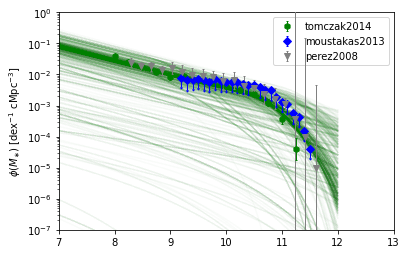

In [5]:
#look at the raw LF samples
# ax = anl.ReconstructedFunction('galaxy_lf', ivar=[6, None], samples='all', color='b', alpha=0.01)

# ax.set_yscale('log')
z = 0.35
# 0.35, 0.875, 1.125, 1.75, 2.25, 2.75

gpop = ares.analysis.GalaxyPopulation()

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='g', alpha=0.01)

# Plot any data within dz=0.1 of z=6
gpop.PlotSMF(z, ax=ax, round_z=0.2, log10Mass=True)

# ax.semilogy()

# ax.set_ylim(1e-35, 1)
# ax.set_xlim(1e7, 1e13)

ax.legend()
pl.show()

# ax = anl_2.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples='all', color='b', alpha=0.01)
# gpop.PlotSMF(z, ax=ax, round_z=0.2)

In [6]:
params = \
['pq_func_par0[0]',
    'pq_func_par2[0]', 

    #norm
    'pq_func_par0[1]',
    'pq_func_par2[1]', 

    #gamma
    'pq_func_par0[2]',
    'pq_func_par2[2]', 

    #peak mass
    'pq_func_par0[3]',
    'pq_func_par2[3]' 
]

covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))

pq_func_par0[0]: 1.002991e+00
pq_func_par2[0]: 1.655912e-01
pq_func_par0[1]: 1.119679e-01
pq_func_par2[1]: -5.589733e-01
pq_func_par0[2]: 5.049366e-01
pq_func_par2[2]: -4.726350e-01
pq_func_par0[3]: 1.197222e+01
pq_func_par2[3]: 3.055058e-01


0 of 1600 chain elements ignored because of chain links with inf's/nan's.


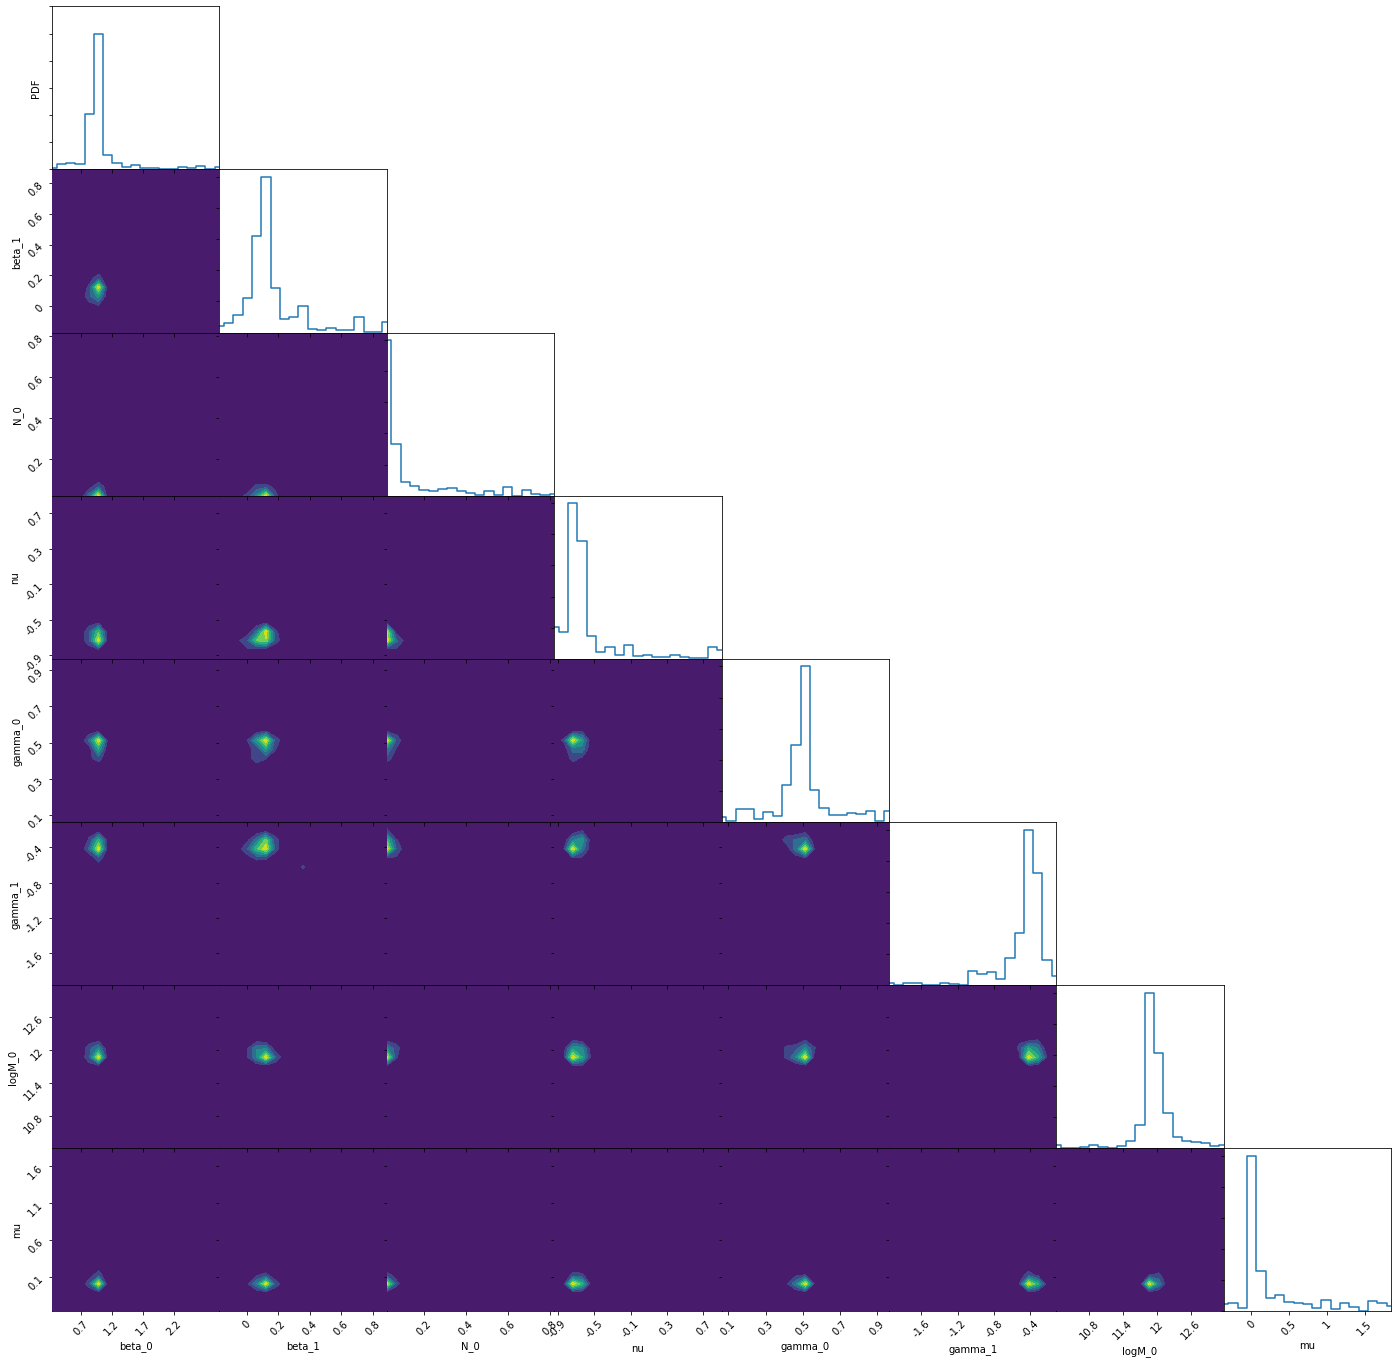

In [7]:

trig = anl.TrianglePlot(pars=params)

In [1]:
anl.WalkerTrajectoriesMultiPlot(best_fit='mode')
# mode: 2190
# median: -3171602.2183875367

NameError: name 'anl' is not defined

In [9]:
anl.max_likelihood_parameters()

{'pq_func_par0[0]': 0.9028722964778572,
 'pq_func_par2[0]': 0.1380588653443749,
 'pq_func_par0[1]': 0.01555427217037627,
 'pq_func_par2[1]': -0.6765033097877754,
 'pq_func_par0[2]': 0.5459892049631929,
 'pq_func_par2[2]': -0.4640570696816827,
 'pq_func_par0[3]': 11.957409477838937,
 'pq_func_par2[3]': 0.0030762871185587067}

In [10]:
covar = anl.CovarianceMatrix(params)

if len(covar[0]) == 1:
    print("{}: {}".format(params[0], covar[0][0]))
else:
    for i in range(len(covar[0])):
        print("{}: {:e}".format(params[i], covar[0][i]))
        
fit_mean = np.array(covar[0])

pq_func_par0[0]: 1.002991e+00
pq_func_par2[0]: 1.655912e-01
pq_func_par0[1]: 1.119679e-01
pq_func_par2[1]: -5.589733e-01
pq_func_par0[2]: 5.049366e-01
pq_func_par2[2]: -4.726350e-01
pq_func_par0[3]: 1.197222e+01
pq_func_par2[3]: 3.055058e-01


In [11]:
pars_ch = {}
for i in range(len(covar[0])):
    pars_ch[params[i]] = covar[0][i]
    
pars_mean = ares.util.ParameterBundle("emma:model1")

pars_mean.update(pars_ch)
# print(pars_best)
pop_mean = ares.populations.GalaxyPopulation(**pars_mean)

In [12]:
fit_best_like = anl.max_likelihood_parameters()

for i in range(len(covar[0])):
    print(anl.get_1d_error(params[i])) #(maximum likelihood value, positive error, negative error).

(0.9028722964778572, array([0.15724255, 0.05396978]))
(0.1380588653443749, array([0.17105313, 0.10297301]))
(0.01555427217037627, array([0.22118075, 0.00226267]))
(-0.6765033097877754, array([0.22554553, 0.09999912]))
(0.5459892049631929, array([0.03276613, 0.12334193]))
(-0.4640570696816827, array([0.145243  , 0.15666271]))
(11.957409477838937, array([0.18136279, 0.08320037]))
(0.0030762871185587067, array([0.8228751 , 0.00806545]))


In [13]:
pars_best = ares.util.ParameterBundle("emma:model1")

# print(fit_best_like)

pars_best.update(fit_best_like)
# print(pars_best)
pop_best = ares.populations.GalaxyPopulation(**pars_best)

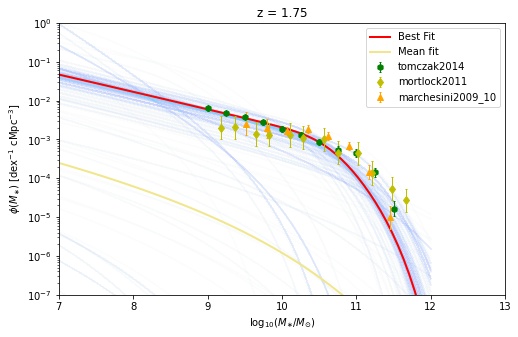

In [19]:
z = 1.75

Ms = np.linspace(7, 13, 80)

# print(Ms)
fig, ax = pl.subplots(figsize=(8, 5))

ls_best = pop_best.StellarMassFunction(z, Ms)

# print(ls_best)

ls_mean = pop_mean.StellarMassFunction(z, Ms)
# print(ls_mean)

ax = anl.ReconstructedFunction('galaxy_smf', ivar=[z, None], samples=1000, color='lightskyblue', alpha=0.01, ax=ax)

obslf = ares.analysis.GalaxyPopulation()
obslf.PlotSMF(z=z, ax=ax, round_z=0.2, log10Mass=True)

ax.semilogy(Ms, ls_best, label='Best Fit', color="red", linewidth=2)
pl.semilogy(Ms, ls_mean, label='Mean fit', color="khaki", linewidth=2)

pl.title("z = %.2f" %z)
ax.set_xlabel('log$_{10}(M_{\\ast} / M_{\odot})$')
pl.legend()
# pl.ylim(1e-18, 1e2)
pl.show()

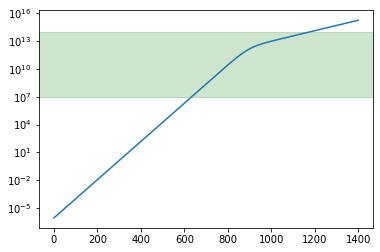

In [15]:
#looking at good stellar mass range

pl.axhspan(1e7, 1e14, alpha=0.2, color='green')

# pl.semilogy(pop_best.SMHM(1.75))
pl.semilogy(pop_mean.SMHM(0.35))

pl.show()

In [20]:
ls_mean = pop_mean.StellarMassFunction(z, Ms)

pop_mean.SMHM(1)
print(ls_mean)

[2.49822580e-04 2.26493627e-04 2.05118022e-04 1.85553620e-04
 1.67661787e-04 1.51309492e-04 1.36380821e-04 1.22765665e-04
 1.10358092e-04 9.90636406e-05 8.87952767e-05 7.94689589e-05
 7.10076589e-05 6.33427258e-05 5.64077912e-05 5.01403302e-05
 4.44862967e-05 3.93933606e-05 3.48110504e-05 3.06970190e-05
 2.70098440e-05 2.37099775e-05 2.07633576e-05 1.81377656e-05
 1.58024249e-05 1.37301008e-05 1.18958851e-05 1.02760305e-05
 8.84900590e-06 7.59570493e-06 6.49795650e-06 5.53897170e-06
 4.70426790e-06 3.98011061e-06 3.35361281e-06 2.81394989e-06
 2.35084870e-06 1.95481135e-06 1.61770347e-06 1.33206110e-06
 1.09104055e-06 8.88700374e-07 7.19753054e-07 5.79399386e-07
 4.63447153e-07 3.68270441e-07 2.90618829e-07 2.27653464e-07
 1.76985337e-07 1.36506471e-07 1.04388876e-07 7.91338042e-08
 5.94419235e-08 4.42126745e-08 3.25533747e-08 2.37160469e-08
 1.70827987e-08 1.21602863e-08 8.55042436e-09 5.93381934e-09
 4.06149731e-09 2.74044984e-09 1.82117267e-09 1.19085907e-09
 7.65794625e-10 4.838070

582.8909234863956
[582.8115076415592 582.8115076415592 -39.719764342703854
 -39.719764342703854 926.0419475570698 926.0419475570698 869.2369046260826
 869.2369046260826 391.3434723966171 539.8811621686109 582.8909234863956
 582.8441217253741 127.99177997082307 127.99177997082307 887.3512980014402
 919.3681402776942 203.56089389204584 203.56089389204584
 328.68417135375324 328.19384348793807]


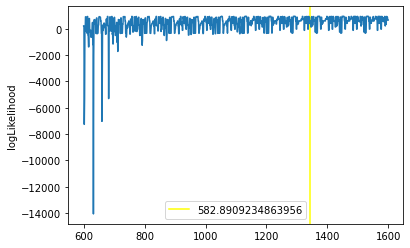

In [21]:
ticks = np.linspace(0, len(anl.logL)-1, len(anl.logL))

xstart = 600

maxL = anl.logL[1344]

print(anl.logL[1344])
print(anl.logL[1344-10:1344+10])

pl.axvline(x=1344, color="yellow", label=str(maxL))

pl.plot(ticks[xstart:], anl.logL[xstart:])
# pl.plot(ticks, anl.logL)
pl.ylabel("logLikelihood")

# pl.ylim(-500,)
pl.legend()
pl.show()